# STEP 1: Determination of speed dependent static-pressure error and correction
### coefficient(s): 'ps_q_corr' ($C_{s1,q}, C_{s2,q}$)
### Reference: Master thesis, Kap. 2.2.2, 2.2.3 (basics of air speed calculation) and 4.3 (actual correction functions and coefficients)
#### --> scroll down for speed dependent dynamic-pressure error (coefficient 'q_q_corr' ($C_{q,q}$))  <--



The flow around the aricraft gets altered by the aircraft itself, the wingpod and 5HP, which leads to errors in static-pressure measurements due to compression, deceleration and aceleration of the flow, which is known as 'position error'. The error predominantly depends on the flow velocity ( == aircraft speed) and affects the static- as well as the dynamic-pressure port. There is also a small flwo angle dependent error, which has not been addressed yet. Since the airspeed is calculated by the difference pressure between the dynamic and static pressure port, the dynamic pressure measurement is affected by the static pressure error, too. Therefore, the static-pressure error has to be modelled first and subtracted from the static- as well as dynamic-pressure measurements by applying a correction function. The goal of the calibration routines presented is to quantify the correction coefficients for the correction function.

For this purpose, speed-variation maneuvers have been flown to alternate the dynamic pressure and provoke static-pressure errors. The following routines where designed to process the data of theses maneuvers and retrieve their coefficients.

#### Instructions:
1. create a new and unique configuration file `conf_static_defect_determination_[0-9].py` in the subdir `calibration/static_defect/configurations/` which contains the time stamp of your latest conducted accel-decel maneuver
2. insert the respective raw data files into the `in/` directory
3. copy the a-priori-const file (`calibration/a_priori_const.py`) into the main `wingpod_proc/` directory and rename it to `const.py` after you backed up the old `const.py`
4. enter the name of the configuration file of the accel-decel maneuver in the following cell (variable `conf_file`)

In [1]:
#name of configuration file
conf_file = 'conf_static_defect_determination_1.py'

/home/axel/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Input directory: /home/axel/Dropbox/Dokumente/studium/WeWi/5Loch/python/wingpod_proc/in/
Loading CPT6100 data...
Loading CPT6100 data...
Loading CPT6100 data...
Loading CPT6100 data...
Loading HMT310 data...
Loading USB1608 data...
Loading Novatel data...
Preprocessing data...
Time selected between: '2018-06-07 18:12:33' and '2018-06-07 18:20:20' UTC
Done.
{'polynomial': [-4.138679735910993e-05, 0.12657816922609383, -61.66605266718315], 'determination': 0.9563813428583627}

>>>> COEFFICIENT SET (ps_q_err) : C2=-4.139E-05, C1=1.266E-01 <<<<

Error of estimators within 95% confidence interval: 
[4.74942811e-06 7.91215696e-03 2.89812279e+00]


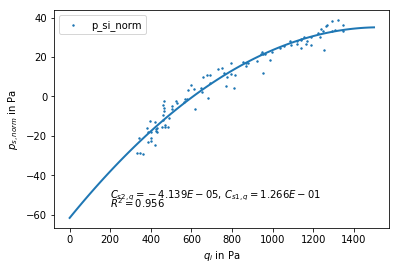

In [2]:
#main routine

import statsmodels.api as sm
import matplotlib.pyplot as plt
import os
from scipy import stats
plt.close()

#needed functions

#barometric formula
def baro_form(p0,z,Tm,g=9.807,R=287.1):
    """
    Barometric formular
    Input:
        p0 - reference pressure in Pa
        z - relative height difference between z and z0 in m
        Tm - mean temperature between z and z0 in K
        g - gravitational acceleration
        R - gas constant for dry air
        
    Output:
        p - pressure at height z in Pa
    """
    
    p=p0*np.exp((-(g*z)/(R*Tm)))
    
    return(p)

def lin_fit(x,y):
    """
    Linear regression using least-squares method with error estimation
    Input:
        x - array, containing x values
        y - array, containing y values
    Output:
        slope - float, slope
        interc - float, intercept
        slope_err - float, slope error
        interc_err - float, intercept error
    """
    
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    
    slope = np.sum((x-x_mean)*(y-y_mean))/(np.sum((x-x_mean)**2))  
    interc = y_mean-slope*x_mean
    
    sse = np.sum((y-(x*slope+interc))**2)
    sigma_e = np.sqrt(sse/(len(x)-2))
    slope_err = sigma_e*np.sqrt(1/np.sum((x-x_mean)**2))
    interc_err = slope_err*np.sqrt(np.sum(x**2)/2)
    
    return(slope,interc,slope_err,interc_err)

def polyfit(x, y, degree):
    """
    Polyfit function using numpy polyfit with an additional
        return of error determinants
    Input:
        x - array, x-values
        y - array, y-values
        degree - int, degree of fit
    Output:
        results - dict, containing coefficients and error matrice
    """
    results = {}
    coeffs = np.polyfit(x, y, degree)
     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()
    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = ssreg / sstot
    
    return(results)

#change directories, copy configuration
par_dir = '/../..' #relative parent directory containing the wingpod_proc software (main_dir)
cwd = os.getcwd() #get current working directory (path of this Jupyter notebook)
main_dir = cwd + par_dir #set main dir

os.system('mv ' + main_dir + '/conf.py ' + main_dir + '/conf.py.bak') #backup old configuration file
os.system('cp ' + cwd + '/configurations/' + conf_file + ' ' + main_dir + '/conf.py') #copy configuration file
os.chdir(main_dir) #change into main_dir

#actual processing of flight
#execute to get data
exec(open('main.py').read())

#calculate mean temperature
t_m = np.mean(data['T'])

#reference altitude (z0)
z0 = np.max(data['height'])#reference pressure at reference altitude
#reference pressure (p0) at z0
p0 = np.mean(data['p_alt'][data['height'] == z0])

#offset (z) from z0
z = data['height']-z0 #z-z_ref

#pressure offset (p) from z
p = baro_form(p0,z,t_m,g=9.807,R=287.1)
data['p_si_norm'] = data['p_alt']-p
x = data['p_spd']
y = data['p_si_norm']
plt.scatter(x[::500],y[::500],s=2)

coeff = polyfit(data['p_spd'][::100],data['p_si_norm'][::100],2)
coeff2 = np.polyfit(data['p_spd'][::100],data['p_si_norm'][::100],2,cov=True)
p = coeff['polynomial']
print(coeff)
print('\n>>>> COEFFICIENT SET (ps_q_err) : C2=%.3E, C1=%.3E <<<<\n' % (p[0], p[1]))
print('Error of estimators within 95% confidence interval: ')
print(np.sqrt(np.diag(coeff2[1]))*1.96)
xp = np.linspace(0,15*100,100)
yp = p[0]*xp**2+p[1]*xp+p[2]
plt.plot(xp,yp,linewidth=2)
plt.text(200,p[2]+10,'$C_{s2,q}=%.3E$, $C_{s1,q}=%.3E$' % (p[0], p[1]))
plt.text(200,p[2]+5, '$R^{2}=$' + str(round(coeff['determination'],3)))

plt.legend(framealpha=0.8)
plt.ylabel(r'$p_{s,norm}$ in Pa')
plt.xlabel(r'$q_{i}$ in Pa')

plt.show()
#apply corrected static pressure values
#data_slic['p_alt_sq'] = data_slic['p_alt']-scale*data_slic['p_spd']-intercept
plt.savefig('static_defect_reg.pdf')

#### Further Instructions:
1. insert the date and time of the flight and the retrieved `ps_q_corr` coefficient set into the `calibration/coeffs.ods` file
2. insert the best suiting (or mean) coefficients into the `const.py` in the main directory before you proceed with the next calibration step

### Done!

# STEP 2: Determination of speed dependent dynamic-pressure error

### coefficient: 'q_q_corr' ($C_{q,q}$)
### Reference: Master thesis, Kap. 2.2.2, 2.2.3 (basics of air speed calculation) and 4.3 (actual correction functions and coefficients)

While the static-pressure error has been removed from both the static- and dynamic-pressure ports, there is still a residual error on the dynamic pressure port only. To compensate this error, a correction function is applied to the dynamic pressure measurements. The linear correction coefficient is gained by a couple of reverse-heading maneuvers which are also used in the $\beta_0$-calibration process. **Therefore, the same configuration files (**`conf_beta_angle_[0-9]-[0|1].py`**) in the ** `calibration/flow angle/configurations/`** directory were used.** The configuration files, which each end with a 0 and 1, represent a pair of a chronologically flown set, which was flown first in one direction (0), then in the other (1).

#### Instructions:
1. reload the Python Kernel to purge all variables and to reset the working directory
2. create a new and unique set of configuration files `conf_beta_angle_[0-9]_0.py` and `conf_beta_angle_[0-9]_1.py` in the subdir `calibration/flow_angle/configurations/` for your latest set of reverse-heading maneuvers
3. insert the respective raw data file into the `in/` directory
4. enter the name of the configuration file you have just created in the following cell (variable `conf_file`) for the first sequence (0) of the flown reverse-heading pair
5. set the `seq` variable to the sequence number (0)
6. run the code
7. repeat step 4 to 6 by setting the sequence no. to 1 (e.g. change 'conf_beta_angle_8_0.py' to 'conf_beta_angle_8_1.py')

In [3]:
conf_file = 'conf_beta_angle_0_1.py'
seq = 1

Input directory: /home/axel/Dropbox/Dokumente/studium/WeWi/5Loch/python/wingpod_proc/in/
Loading CPT6100 data...
Loading CPT6100 data...
Loading CPT6100 data...
Loading CPT6100 data...
Loading HMT310 data...
Loading USB1608 data...
Loading Novatel data...
Preprocessing data...
Time selected between: '2017-08-14 11:03:00' and '2017-08-14 11:04:00' UTC
Done.
Mean wind spd: 5.20876906603489  0.47776803960001113
Mean flight direction: 205.03816617253926
mean height: 2336.444663600774


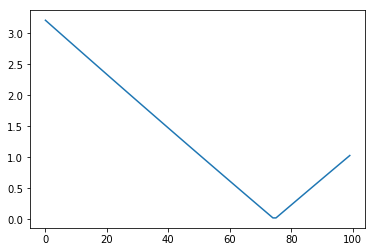


>>>> COEFFICIENT (q_q_corr): C1=-2.424E-02 <<<<



In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')

#guessed values
if seq == 0:
    C_qq_range = [-0.1,0] #guess range
    fineness = 100 #precision of the resulting coefficient
    x_m = np.linspace(C_qq_range[0],C_qq_range[1],fineness)

    #change directories, copy configuration
    par_dir = '/../..' #relative parent directory containing the wingpod_proc software (main_dir)
    cwd = os.getcwd() #get current working directory (path of this Jupyter notebook)
    main_dir = cwd + par_dir #set main dir
    os.chdir(main_dir) #change into main_dir
    
    out = np.zeros((fineness,2)) #allocate empty output matrix
    
os.system('cp ' + cwd + '/../flow_angle/configurations/' + conf_file + ' ' + main_dir + '/conf.py') #copy configuration file

#actual processing of flight
#execute to get data
exec(open('main.py').read())

for k,var in enumerate(x_m):
    C_qq_new = var
    data['q_q_err'] = pp.dyn_press_q_error(data['p_spd_corr'],var)
    data['p_spd_corr_new'] = data['p_spd_corr'] + data['q_q_err']
            
    data.update(wc.wind_out(data['p_alt'], data['p_alt_corr'], data['p_spd'],
                          data['p_spd_corr_new'], data['p_alp'], data['p_bet'],
                          data['T'], data['theta'], data['theta_dot'],
                          data['psi'], data['psi_dot'], data['phi'],
                          data['u_p'], data['v_p'], data['w_p'],
                          alp0, bet0, C_alp, C_bet, L, r, simple=False))
    out[k,seq] = np.mean(data['wspd'])
    if k == int(fineness/2):
        print('Mean wind spd: ' + str(np.mean(data['wspd'])) + '  ' + str(np.std(data['wspd'])))
        print('Mean flight direction: ' + str(np.mean(data['psi'])/np.pi*180))
        print('mean height: ' + str(np.mean(data['height'])))

if seq == 1:  
    diff = abs(out[:,1]-out[:,0])
    plt.plot(diff)
    plt.show()
    out_C_qq = x_m[np.where(diff == np.min(diff))]
    #print('Found best C_qq value ' + str(out_C_qq[i]) + '.')
    #print('Minimum Diff in wspd: ' + str(np.min(diff)))
    print('\n>>>> COEFFICIENT (q_q_corr): C1=%.3E <<<<\n' % out_C_qq)

#### Further instructions:
1. insert the date and time of the flight and the retrieved `q_q_corr` coefficient into the `calibration/coeffs.ods` file and copy the mean value into the `const.py` for the next calibration process

#### Done!